# Covid-19 Turkey 

### Regression for The logistic model - Applied to the Corona Virus

In [1]:
# https://towardsdatascience.com/modeling-functions-78704936477a

In [2]:
# https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import sklearn
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from datapackage import Package

package = Package('https://datahub.io/core/covid-19/datapackage.json')

In [5]:
countries_aggregated_csv = package.get_resource('countries-aggregated_csv').read(keyed=True)
package.get_resource('countries-aggregated_csv').headers

['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths']

In [6]:
# Creating a dataframe object from listoftuples
worldwide_aggregated_df = pd.DataFrame(countries_aggregated_csv)

worldwide_aggregated_df.head(3)

,Confirmed,Country,Date,Deaths,Recovered
0,0,Afghanistan,2020-01-22,0,0
1,0,Albania,2020-01-22,0,0
2,0,Algeria,2020-01-22,0,0


### Select Only Turkey

In [7]:
turkey_df = worldwide_aggregated_df[ worldwide_aggregated_df['Country'] == 'Turkey' ]
turkey_df.tail(3)

,Confirmed,Country,Date,Deaths,Recovered
14600,42282,Turkey,2020-04-09,908,2142
14785,47029,Turkey,2020-04-10,1006,2423
14970,52167,Turkey,2020-04-11,1101,2965


In [8]:
turkey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 170 to 14970
Data columns (total 5 columns):
Confirmed    81 non-null int64
Country      81 non-null object
Date         81 non-null object
Deaths       81 non-null int64
Recovered    81 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.8+ KB


In [9]:
df = turkey_df.loc[:,['Date','Confirmed']]
df = df.reset_index()
df.head()

,index,Date,Confirmed
0,170,2020-01-22,0
1,355,2020-01-23,0
2,540,2020-01-24,0
3,725,2020-01-25,0
4,910,2020-01-26,0


In [10]:
df['days'] = df.index.values
df.head(3)

,index,Date,Confirmed,days
0,170,2020-01-22,0,0
1,355,2020-01-23,0,1
2,540,2020-01-24,0,2


In [11]:
df = df.loc[:,['days','Confirmed']]

df.head(3)

,days,Confirmed
0,0,0
1,1,0
2,2,0


### The Logistic Model Regression 

\begin{equation*}
\text{Logistic Funtion Model:} f(x,a,b,c) = \frac{c}{1+e^{-(x-b)/a}}
\end{equation*}

In [12]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In this formula, we have the variable x that is the time and three parameters: a,b,c.<br/>

* a refers to the infection speed
* b is the day with the maximum infections occurred
* c is the total number of recorded infected people at the infection’s end

In [13]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

fit = curve_fit(logistic_model, x, y)

popt_log, pcov_log = curve_fit(logistic_model,x,y,p0=[2,100,100000])


In [14]:
print(popt_log)
print(pcov_log)

print('\n',fit)

[4.63298706e+00 7.65834461e+01 7.48860586e+04]
[[1.32388310e-02 3.84075678e-02 2.83269407e+02]
 [3.84075678e-02 1.31535880e-01 9.80135852e+02]
 [2.83269407e+02 9.80135852e+02 7.42726252e+06]]

 (array([4.63298057e+00, 7.65834318e+01, 7.48859548e+04]), array([[1.32391454e-02, 3.84092021e-02, 2.83283731e+02],
       [3.84092021e-02, 1.31543489e-01, 9.80201281e+02],
       [2.83283731e+02, 9.80201281e+02, 7.42781913e+06]]))


In [15]:
print("parameters:", popt_log)
a_log = popt_log[0]
b_log = popt_log[1]
c_log = popt_log[2]
print("a:", a_log)
print("b:", b_log)
print("c:", c_log)

parameters: [4.63298706e+00 7.65834461e+01 7.48860586e+04]
a: 4.632987064563347
b: 76.58344614335927
c: 74886.05862730776


In [16]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors[0]

0.11506148527924

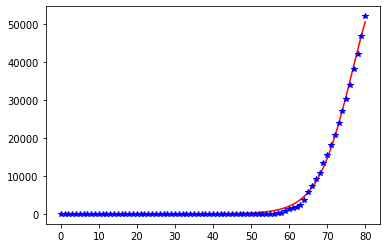

In [17]:
plt.plot(x, logistic_model(x, *popt_log), color='r', label='fit')
plt.plot(x, y, 'b*', label='data')

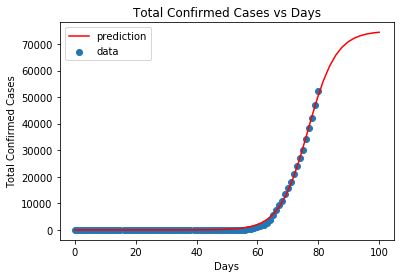

In [18]:
%matplotlib inline
plt.scatter(x, y,label='data')

plt.plot(np.linspace(0,100), logistic_model(np.linspace(0,100),*popt_log), color='r',label='prediction')

plt.title("Total Confirmed Cases vs Days")
plt.xlabel('Days')
plt.ylabel('Total Confirmed Cases')
plt.legend()
plt.show()

In [19]:
print(f'The equation of regression line is {popt_log[2]:.3f} / (1 + exp(-(x-{popt_log[1]:.3f})/{popt_log[0]:.3f}) )')

The equation of regression line is 74886.059 / (1 + exp(-(x-76.583)/4.633) )


In [21]:
print(f'The equation of regression line is {popt_log[2].round(2)} / (1 + e^(-(x-{popt_log[1].round(2)})/{popt_log[0].round(2)}) )')

The equation of regression line is 74886.06 / (1 + e^(-(x-76.58)/4.63) )


### We can use the fsolve function of scipy to numerically find the root of the equation that defines the infection end day.

In [22]:
sol = int(fsolve(lambda x : logistic_model(x,*popt_log) - int(c_log),b_log))
sol

141

In [23]:
from datetime import datetime, timedelta

In [24]:
first_day = turkey_df['Date'].iloc[0]
print(first_day)

#add sol days to first_day
infection_end_day = first_day + timedelta(days = sol)
print('Infection end day: ', infection_end_day)

2020-01-22
Infection end day:  2020-06-11


## Exponential model

\begin{equation*}
\text{Exponential Funtion Model:} f(x,a,b,c) = {a e^{b(x-c)}}
\end{equation*}

In [51]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

x = list(df.iloc[50:,0])
y = list(df.iloc[50:,1])

popt_exp, pcov_exp = curve_fit(exponential_model,x,y)

In [52]:
print("parameters:", popt_exp)
a_exp = popt_exp[0]
b_exp = popt_exp[1]
c_exp = popt_exp[2]
print("a:", popt_exp[0])
print("b:", popt_exp[1])
print("c:", popt_exp[2])

parameters: [ 5.82142836  0.13633617 12.77949652]
a: 5.82142836155853
b: 0.13633616646470634
c: 12.779496521519873


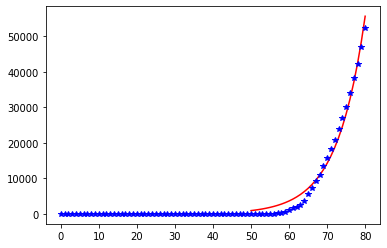

In [53]:
plt.plot(x, exponential_model(list(df.iloc[50:,0]), *popt_exp), color='r', label='fit')

x = list(df.iloc[0:,0])
y = list(df.iloc[0:,1])
plt.plot(x, y, 'b*', label='data')

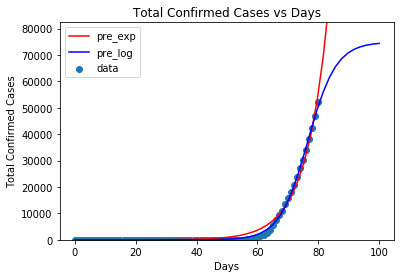

In [54]:
%matplotlib inline
plt.scatter(x, y,label='data')

plt.plot(np.linspace(0,100), exponential_model(np.linspace(0,100),*popt_exp), color='r',label='pre_exp')
plt.plot(np.linspace(0,100), logistic_model(np.linspace(0,100),*popt_log), color='b',label='pre_log')

plt.title("Total Confirmed Cases vs Days")
plt.xlabel('Days')
plt.ylabel('Total Confirmed Cases')
plt.ylim(0, c_log*1.1)
plt.legend()
plt.show()

In [55]:
y_pred_logistic = logistic_model(x,*popt_log)
y_pred_exp      = exponential_model(x,*popt_exp)
print('Logistic model MSE:', mean_squared_error(y,y_pred_logistic))
print('Exponential model MSE:', mean_squared_error(y,y_pred_exp))

Logistic model MSE: 268072.1202128857
Exponential model MSE: 1525863.8409186092
